Создание модели нейронной сети по обнаружению мин с точностью до 90 % на тестовой выборке. 

Данные с сонара предоставлены в виде файла csv

In [ ]:
# импорт библиотек
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
import pandas as pd # Библиотека pandas
from google.colab import files # Импорт файлов
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

### Загрузка файлов

In [ ]:
# загрузим файлы в окружение ноутбука
!wget http://m.ric.media/nu/sonar.csv
!wget http://m.ric.media/nu/model_sonar_90.h5

--2021-09-23 12:02:33--  http://m.ric.media/nu/sonar.csv
Resolving m.ric.media (m.ric.media)... 176.213.150.19
Connecting to m.ric.media (m.ric.media)|176.213.150.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87776 (86K) [text/csv]
Saving to: ‘sonar.csv’

sonar.csv           100%[===================>]  85.72K   144KB/s    in 0.6s    

2021-09-23 12:02:37 (144 KB/s) - ‘sonar.csv’ saved [87776/87776]

--2021-09-23 12:02:37--  http://m.ric.media/nu/model_sonar_90.h5
Resolving m.ric.media (m.ric.media)... 176.213.150.19
Connecting to m.ric.media (m.ric.media)|176.213.150.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39264 (38K) [text/plain]
Saving to: ‘model_sonar_90.h5’

model_sonar_90.h5   100%[===================>]  38.34K  97.9KB/s    in 0.4s    

2021-09-23 12:02:38 (97.9 KB/s) - ‘model_sonar_90.h5’ saved [39264/39264]



In [ ]:
# Загружаем файлы
# files.upload()
!ls # Выводим содержимое корневой папки

model.h5  model_sonar_90.h5  sample_data  sonar.csv


### Загрузка данных

In [ ]:
# загружаем данные из файла sonar.csv
df = pd.read_csv('sonar.csv', header=None) # загружаем без строки заголовка
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.0660,0.2273,0.3100,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.5550,0.6711,0.6415,0.7104,0.8080,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.0510,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0000,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.3250,0.3200,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.1840,0.1970,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.0530,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,0.6333,0.7060,0.5544,0.5320,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.5070,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.0130,0.0106,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.4060,0.3973,0.2741,0.3690,0.5556,0.4846,0.3140,0.5334,0.5256,0.2520,0.2090,0.3559,0.6260,0.7340,0.6120,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.3210,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.5730,0.5399,0.3161,0.2285,0.6995,1.0000,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.2430,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.0230,0.0046,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [ ]:
# размерность датафрейма
df.shape

(208, 61)

In [ ]:
# получим X(параметры) и Y(метки классов) из датасета
dataset = df.values               # берем содержимое датафрейма в виде numy массива
X = dataset[:,0:60].astype(float) # все строки, столбцы 0-59, преобразуем в тип float
Y = dataset[:,60]                 # все строки, столбец 60
Y[Y=='R'] = '0'                   # значение "не мина" делаем строковым "0"
Y[Y=='M'] = '1'                   # значение "мина" делаем строковым "1" 
Y = Y.astype(int)                 # преобразуем тип Y в числовой "int"

# выведем размерности и содержимое Y
print('Размерность X:', X.shape)
print('Размерность Y:', Y.shape)
print('Y:', Y) # массив меток отсортирован по метке - split делаем аккуратно !!!

Размерность X: (208, 60)
Размерность Y: (208,)
Y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Создаем обучающую, проверочную и тестовую выборки

In [ ]:
# выделим из общей 20% на тестовую выборку, перемешаем данные
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
# выделим из обучающей часть на проверочную выборку, перемешаем данные
x_train_new, x_val, y_train_new, y_val = train_test_split(x_train, y_train, test_size=0.4, shuffle=True)
# выведем размерности выборок
print('Размерность x_train:', x_train.shape)
print('Размерность x_train_new:', x_train_new.shape)
print('Размерность x_val:', x_val.shape)
print('Размерность x_test:', x_test.shape)
print('Размерность y_train:', y_train.shape)
print('Размерность y_train_new:', y_train_new.shape)
print('Размерность y_val:', y_val.shape)
print('Размерность y_test:', y_test.shape)

Размерность x_train: (166, 60)
Размерность x_train_new: (99, 60)
Размерность x_val: (67, 60)
Размерность x_test: (42, 60)
Размерность y_train: (166,)
Размерность y_train_new: (99,)
Размерность y_val: (67,)
Размерность y_test: (42,)


### Создаем нейронную сеть

Epoch 1/100
13/13 [==============================] - 1s 14ms/step - loss: 0.6969 - accuracy: 0.5354 - val_loss: 0.6831 - val_accuracy: 0.5970
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6780 - accuracy: 0.5455 - val_loss: 0.6784 - val_accuracy: 0.5373
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6521 - accuracy: 0.6566 - val_loss: 0.6718 - val_accuracy: 0.5672
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.6473 - accuracy: 0.6162 - val_loss: 0.6637 - val_accuracy: 0.6269
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6297 - accuracy: 0.6869 - val_loss: 0.6477 - val_accuracy: 0.6567
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6095 - accuracy: 0.7475 - val_loss: 0.6470 - val_accuracy: 0.6119
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5847 - accuracy: 0.7576 - val_loss: 0.6296 - val_accuracy: 0.6567
Epoch 8/100


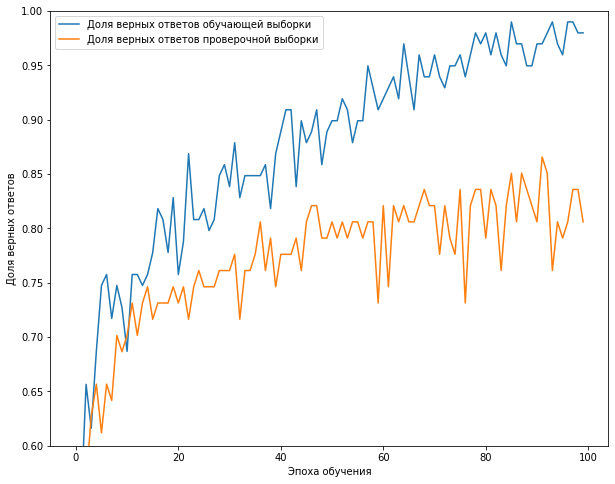

In [ ]:
# создаем сеть
model = Sequential()

# добавляем слои
#model.add(BatchNormalization(input_shape=(60,)))  # слой нормализации
model.add(Dense(60, input_shape=(60,), activation='relu'))           # полносвязный слой 
model.add(Dropout(0.2))                           # слой отключения нейронов, 20% нейронов будут 'выключены'
#model.add(BatchNormalization())                   # слой нормализации
model.add(Dense(30, activation='relu'))           # полносвязный слой
model.add(Dropout(0.2))                           # слой отключения нейронов, 20% нейронов будут 'выключены'
#model.add(BatchNormalization())                   # слой нормализации
model.add(Dense(1, activation='sigmoid'))        # выходной слой

# отобразим данные созданной модели
#model.summary()

# компилируем сеть
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# обучаем сеть
history = model.fit(x_train_new,
                    y_train_new,
                    batch_size=8,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

# history = model.fit(x_train,
#                     y_train,
#                     batch_size=8,
#                     epochs=60,
#                     validation_split=0.4,
#                     verbose=1)

# вычисляем результаты на тестовой выборке
#print()
scores = model.evaluate(x_test, y_test, verbose=0)
# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print('\nДоля верных ответов на тестовых данных, в процентах: {:.2%})\n'\
        .format(scores[1]))

# задаем размер полотна
plt.figure(figsize=(10,8))
# выводим график точности на обучающей выборке
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов обучающей выборки')
# выводим график точности проверочной выборки
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов проверочной выборки')
# размер осей
plt.ylim(0.6,1)
# подписываем оси
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
# вывод легенды и графика
plt.legend()
plt.show()



In [ ]:
# сохраним модель
model.save_weights('model.h5')
# загрузим модель
#model.load_weights('model_sonar_90.h5')

### Меняем шаг обучения (если необходимо)

Epoch 1/100
13/13 [==============================] - 1s 16ms/step - loss: 0.1268 - accuracy: 0.9495 - val_loss: 0.7633 - val_accuracy: 0.8507
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0786 - accuracy: 0.9596 - val_loss: 0.9549 - val_accuracy: 0.8209
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0849 - accuracy: 0.9596 - val_loss: 0.7629 - val_accuracy: 0.7761
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0768 - accuracy: 0.9798 - val_loss: 0.7020 - val_accuracy: 0.8060
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0612 - accuracy: 0.9798 - val_loss: 0.6530 - val_accuracy: 0.7910
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.7072 - val_accuracy: 0.7761
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0644 - accuracy: 0.9697 - val_loss: 0.8421 - val_accuracy: 0.7612
Epoch 8/100


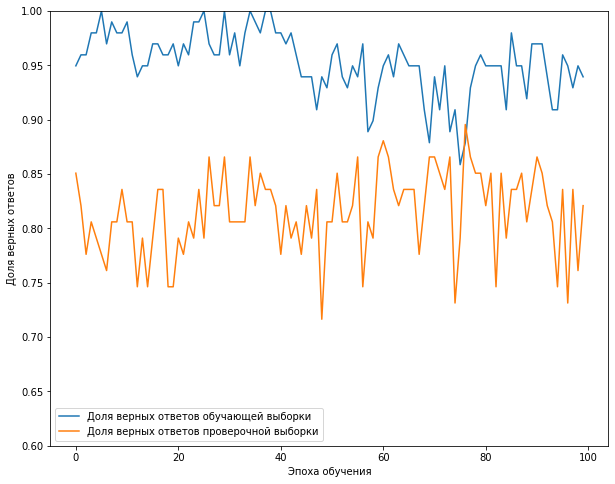

In [ ]:
# компилируем сеть
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=['accuracy'])

# обучаем сеть
history = model.fit(x_train_new,
                    y_train_new,
                    batch_size=8,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

# history = model.fit(x_train,
#                     y_train,
#                     batch_size=8,
#                     epochs=60,
#                     validation_split=0.4,
#                     verbose=1)

# вычисляем результаты на тестовой выборке
#print()
scores = model.evaluate(x_test, y_test, verbose=0)
# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print('\nДоля верных ответов на тестовых данных, в процентах: {:.2%})\n'\
        .format(scores[1]))

# задаем размер полотна
plt.figure(figsize=(10,8))
# выводим график точности на обучающей выборке
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов обучающей выборки')
# выводим график точности проверочной выборки
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов проверочной выборки')
# размер осей
plt.ylim(0.6,1)
# подписываем оси
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
# вывод легенды и графика
plt.legend()
plt.show()



In [ ]:
# сохраним модель
model.save_weights('model.h5')
# загрузим модель
#model.load_weights('model_sonar_90.h5')

### Контрольная проверка результатов на тестовом наборе данных


In [ ]:
# сохраним модель
#model.save_weights('model.h5')
# загрузим модель
model.load_weights('model_sonar_90.h5')

In [ ]:
# вычисляем результаты на тестовой выборке
#print()
scores = model.evaluate(x_test, y_test, verbose=0)
# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print('\nДоля верных ответов на тестовых данных, в процентах: {:.2%})\n'\
        .format(scores[1]))


Доля верных ответов на тестовых данных, в процентах: 90.48%)

